# b_model_v2

## Experimental notes

In [1]:
from IPython.display import Image

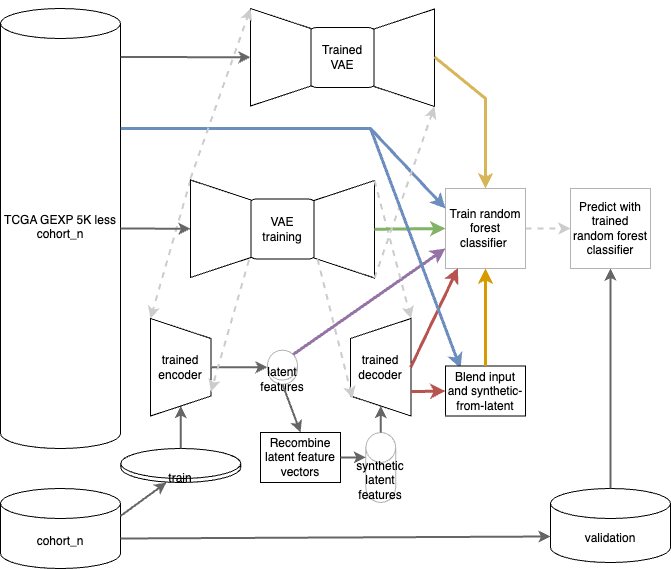

In [2]:
Image(filename='../g_learning_curves/generic_process_flow.png', width = 500)

In [ ]:
# 2023-01-10 Tuesday
# Add input feature recombination block to schematic
# Add encoder for validation of latent
# Remove extra blue and red arrow

## Imports

In [3]:
%whos

Variable   Type    Data/Info
----------------------------
Image      type    <class 'IPython.core.display.Image'>


In [4]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score
from statannot import add_stat_annotation

## VAE setup

In [46]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Directories

In [6]:
mkdir i_o/b_model_v2

In [5]:
v = 'b_model_v2'

In [ ]:
# directory setup for cobort_n to take b_model output

In [36]:
mkdir i_o/b_model_v2/MESO

In [37]:
mkdir i_o/b_model_v2/MESO/decoded_objs

In [38]:
mkdir i_o/b_model_v2/MESO/front_end_box

In [39]:
mkdir i_o/b_model_v2/MESO/latent_objs

In [40]:
mkdir i_o/b_model_v2/MESO/learn_curve

In [41]:
mkdir i_o/b_model_v2/MESO/loss_plots

In [42]:
mkdir i_o/b_model_v2/MESO/take-off_points

In [43]:
ls i_o/b_model_v2/MESO

decoded_objs/    latent_objs/     loss_plots/
front_end_box/   learn_curve/     take-off_points/


## Read data / training protocol setup
Define pre-train and fine-tune sets

In [15]:
file_paths_no_LGGGGBM = sorted(
    glob.glob(
        '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

In [ ]:
file_paths_no_LGGGGBM

In [16]:
len(file_paths_no_LGGGGBM)

25

In [17]:
TCGA_less_LGGGGBM_no_n = ['../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 # '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

In [18]:
pre_train_file = pd.DataFrame()
for path in TCGA_less_LGGGGBM_no_n:
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

In [21]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[13], # luadlusc are 11-13 depending on LGGGBM drop
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'MESO'

## Color set

In [22]:
inp_blu = sns.color_palette("bright")[0]
lat_prp = sns.color_palette("bright")[4]
dec_grn = sns.color_palette("bright")[2]
syn_lat_red = sns.color_palette("bright")[3]
syn_inp_yel = sns.color_palette("bright")[8]
syn_blnd_org = sns.color_palette("bright")[1]

## Validation threshold, storage frames, pre-flight checks

In [23]:
74/2

37.0

In [24]:
trn_size = 37

In [25]:
repeats = 10 # Front-end random forest repeats

In [26]:
inpt_val = pd.DataFrame()
lat_val = pd.DataFrame()
dec_val = pd.DataFrame()
synth_lat_val = pd.DataFrame()
synth_inpt_val = pd.DataFrame()
blend_inpt_synthFrmLat_val = pd.DataFrame()

In [27]:
v

'b_model_v2'

In [28]:
ls i_o/ # Write additional feature engineering files into here (g_line_curves/i_o)

b_model/    b_model_v2/


In [29]:
fine_tune_file.Labels.value_counts()

MESO_1    20
MESO_2    20
MESO_3    19
MESO_4    15
Name: Labels, dtype: int64

In [31]:
mega_frame = pd.DataFrame() # to front-end box

## Replicates experimental cycle point

In [ ]:
# Start LUSC at replicate 1, 74 samples

In [32]:
val_split = 'vs01@'+str(trn_size)
trn = fine_tune_file.sample(trn_size)
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]
print(val_split)
if trn.Labels.value_counts().min() < 3:
    print('Undersampled subtype')
else:
    print('Good to go, minimum sample count is',trn.Labels.value_counts().min())

vs01@37
Good to go, minimum sample count is 7


In [33]:
trn.Labels.value_counts()

MESO_4    12
MESO_3    11
MESO_2     7
MESO_1     7
Name: Labels, dtype: int64

## Input validation

In [34]:
print('Start input validation with RF')
val_inpt_acrcy_lst = []
val_inpt_running_average = []

X_trn = trn.iloc[:, 1:]
y_trn = trn.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]

for r in list(range(0, repeats)):
    if r == 5:
        print('Half way to 10 rpts')    
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_inpt_acrcy_lst.append(val_raw_acc)
    val_inpt_running_average.append(mean(val_inpt_acrcy_lst))
inpt_val.insert(0, val_split, val_inpt_running_average)
print('Input transfer predictions complete')

Start input validation with RF
Half way to 10 rpts
Input transfer predictions complete


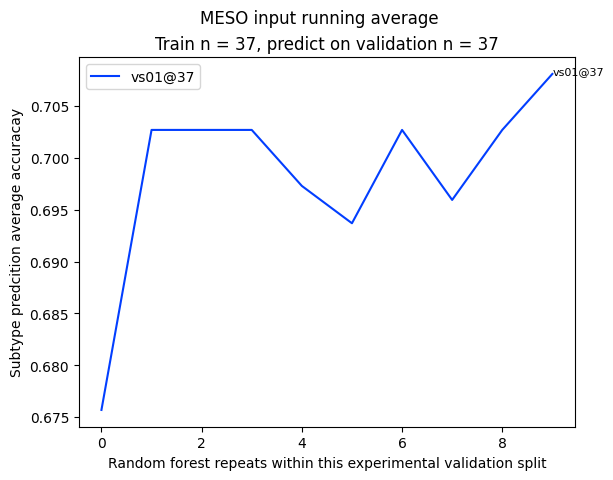

In [44]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = inp_blu, label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input running average')
plt.title('Train n = '+str(
    len(trn))+', predict on validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE pre-training and fine-tuning

In [ ]:
# Re-pre-training the VAE for validation split (?)
# Solution: Run multiple pre-trainings with same validation split
# That's crazy. Is it worth it? Technical noise along with random forest stochasticity

Metal device set to: Apple M1 Max


2023-01-10 16:11:15.525995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 16:11:15.526423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-10 16:11:15.534677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-10 16:11:15.546426: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-10 16:11:15.552728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 16:11:15.590305: I tensorflow/core/grappler/optimizers/custom_graph

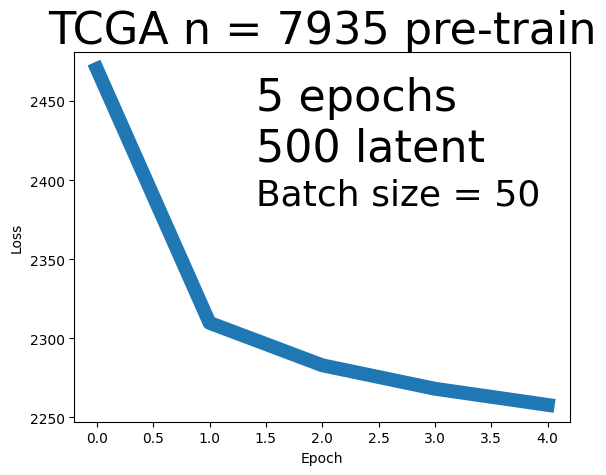

In [47]:
# Pre-train

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 500
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

pre_train_epochs = 5

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],
            epochs=pre_train_epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )
plt.annotate('Batch size = '+str(batch_size),        
            xy = (.4, .62), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on_file_write+'_epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+

    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

In [ ]:
# Looks ok, could try pre-train epoch counts in the range of 3-10

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-10 16:11:49.665116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 16:11:49.757509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


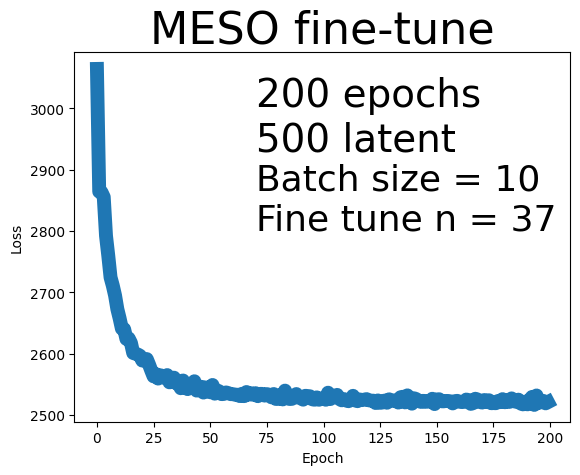

In [48]:
# Fine-tuning

train_file = trn
pre_trn = fit_on_file_write
fit_on = trn.index.name

fine_tune_epochs = 200
batch_size = 10

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],
            epochs = fine_tune_epochs, batch_size=batch_size, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',     
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 28
            )
plt.annotate('Batch size = '+str(batch_size)+
            '\nFine tune n = '+str(trn.shape[0]),             
            xy = (.4, .65), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])),
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index)
latent_object.index.name = trn.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/latent_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/decoded_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

In [ ]:
# MESO looks massively overfit at 200 fune-tune epochs
# Compare 5 replicates at 100 epochs

## Latent validation

In [49]:
val_encoded = pd.DataFrame(encoder.predict(
    val.iloc[:, 1:]),
        index = val.index)
val_encoded_labeled = pd.concat(
    [pd.DataFrame(val.Labels),
     val_encoded] , axis =1)

In [50]:
# Latent to random forest
print('Latent validation start')
X_trn = latent_object.iloc[:, 1:]
y_trn = latent_object.iloc[:, 0]
X_val = val_encoded_labeled.iloc[:, 1:]
y_val = val_encoded_labeled.iloc[:, 0] 
val_lat_raw_acc_lst = []
val_lat_running_average = []
for r in list(range(0, repeats)):
    if r == 5:
        print('five done')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_lat_raw_acc_lst.append(val_raw_acc)
    val_lat_running_average.append(mean(val_lat_raw_acc_lst))
lat_val.insert(0, val_split, val_lat_running_average)
print('Latent validation complete')

Latent validation start
five done
Latent validation complete


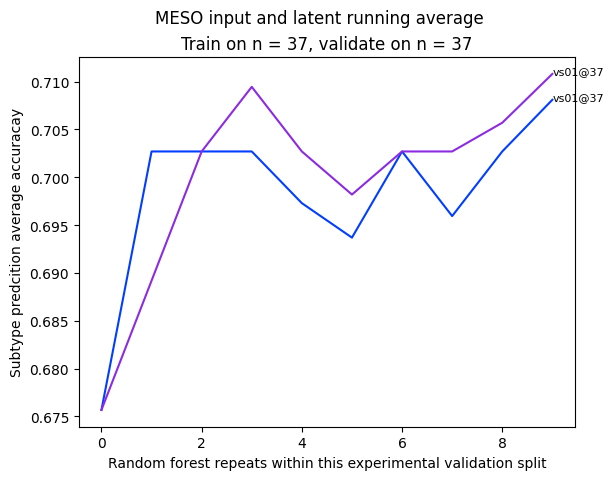

In [51]:
# Latent vs. input front-end plot
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = inp_blu, label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = lat_prp, label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')

plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
# MESO latent is tracking the input, replicate one

## Decoded validation

In [52]:
# Decoded validation
print('Decoded validation start')
X_trn = decoded_labeled.iloc[:, 1:]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

val_dec_raw_acc_lst = []
val_dec_running_average = []

for r in list(range(0, repeats)):
    if r == 5:
        print('half done') 
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_dec_raw_acc_lst.append(val_raw_acc)
    val_dec_running_average.append(mean(val_dec_raw_acc_lst))
dec_val.insert(0, val_split, val_dec_running_average)
print('Decoded validation complete')

Decoded validation start
half done
Decoded validation complete


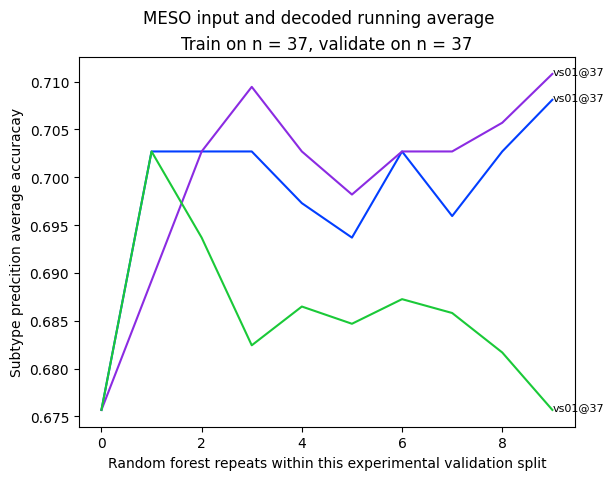

In [53]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = inp_blu, label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = lat_prp, label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = dec_grn, label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and decoded running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Synthetic sample generation

### Latent synthetic

In [54]:
# Three random real samples recombined per synthetic sample generated
print('Starting', val_split, 'synth gen from latent')
synth_in_count = 3
synth_sub_len = 100

synth_ndx_strt = 0
synth_full_frame = pd.DataFrame(columns = latent_object.columns)

for subtype in sorted(latent_object.Labels.unique()):  
    print(subtype)
    sub = latent_object[latent_object.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        input_sample_set = sub.sample(synth_in_count)
        new_samp_vec = []
        for col in input_sample_set.iloc[:, 1:]:
            vals_inpt = input_sample_set.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synthetic from latent done, '+str(synth_sub_len)+' samples generated for each subtype')

Starting vs01@37 synth gen from latent
MESO_1
100
MESO_2
100
MESO_3
100
MESO_4
100
Synthetic from latent done, 100 samples generated for each subtype


In [55]:
synth_lat_dec = pd.concat([synth_full_frame.iloc[:, 0],
                       pd.DataFrame(decoder.predict(synth_full_frame.iloc[:, 1:]), index = synth_full_frame.index)],
                     axis = 1)
synth_lat_dec.columns = trn.columns

In [56]:
# Validate synthetic: train on synthetic latent decoded, predict on validation

print('Synth latent validation start')
X_trn = synth_lat_dec.iloc[:, 1:] # Train on decoded synthetic latent
y_trn = synth_lat_dec.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

synth_lat_raw_acc_lst = []
synth_lat_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half')
    
    clf_trn = RandomForestClassifier() # Initialize classifier
    clf_trn.fit(X_trn, y_trn)
    synth_lat_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    synth_lat_raw_acc_lst.append(synth_lat_raw_acc) # Box plots
    synth_lat_running_average.append(mean(synth_lat_raw_acc_lst))
synth_lat_val.insert(0, val_split, synth_lat_running_average)
print('Synth latent complete')

Synth latent validation start
half
Synth latent complete


In [57]:
# Maybe the fine-tune needs more epochs down in the flat of loss curve?

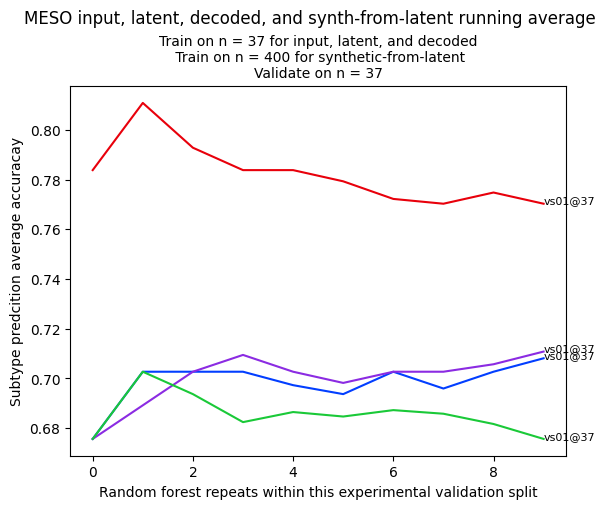

In [58]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = inp_blu, label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = lat_prp, label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = dec_grn, label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = syn_lat_red, label = run)
    plt.annotate(run, (9, synth_lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input, latent, decoded, and synth-from-latent running average',
            y = 1.04)
plt.title('Train on n = '+str(
    len(trn))+' for input, latent, and decoded'+
          '\n Train on n = '+str(len(synth_lat_dec))+' for synthetic-from-latent'
          '\nValidate on n = '+str(
    len(val)), size = 10)
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
# Options: manually test fine-tune epochs
    # automate with shell scripts to check fine-tune epoch reduction
    # Put reinforcement agent to the experiment set up as environment

### Input synthetic

In [59]:
print('Starting', val_split, 'synth gen from input')
synth_ndx_strt = 0
synth_inpt_frame = pd.DataFrame(columns = latent_object.columns)
# synth_sub_len = 100 # Set in the latent sample generator, retain here
for subtype in sorted(trn.Labels.unique()):
    start = time.time()
    print(subtype)
    sub = trn[trn.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        trpl = sub.sample(3)
        new_samp_vec = []
        for col in trpl.iloc[:, 1:]:
            vals_inpt = trpl.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_inpt_frame = pd.concat(
        [synth_inpt_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
    print('loop time: ', round(time.time() - start, 2))
print('Synth from input done, '+str(synth_sub_len)+' samples for each subtype')

Starting vs01@37 synth gen from input
MESO_1
100
loop time:  21.39
MESO_2
100
loop time:  21.38
MESO_3
100
loop time:  21.64
MESO_4
100
loop time:  21.59
Synth from input done, 100 samples for each subtype


In [60]:
synth_input_decoded = pd.DataFrame(decoder.predict(encoder.predict(synth_inpt_frame.iloc[:, 1:])),
                       index = synth_inpt_frame.index, columns = synth_inpt_frame.iloc[:, 1:].columns)
synth_input_decoded = pd.concat([synth_inpt_frame.iloc[:, 0], synth_input_decoded], axis = 1)
synth_input_decoded.columns = fine_tune_file.columns

In [61]:
# Synthetic samples from input val
print('Start synth input accuracy')
synth_input_raw_acc_lst = []
synth_input_running_average = []
X_trn = synth_input_decoded.iloc[:, 1:]
y_trn = synth_input_decoded.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0] 

for r in list(range(0, repeats)):
    if r == 5:
        print('5 repeats complete')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    
    synth_input_raw_acc_lst.append(raw_acc)
    synth_input_running_average.append(mean(synth_input_raw_acc_lst))
synth_inpt_val.insert(0, val_split, synth_input_running_average)
print('Input synth validation complete')

Start synth input accuracy
5 repeats complete
Input synth validation complete


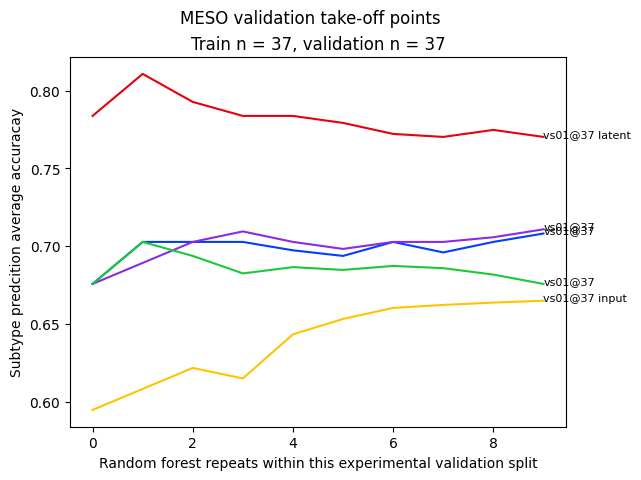

In [62]:
# Final interactive check plot
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = inp_blu, label = run)
    plt.annotate(run, (9, inpt_val[run][9]),fontsize = 8,)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = lat_prp, label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = dec_grn, label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = syn_lat_red, label = run)
    plt.annotate(run+' latent', (9, synth_lat_val[run][9]), fontsize = 8)
for run in synth_inpt_val.columns:
    plt.plot(synth_inpt_val[run], color = syn_inp_yel, label = run)    
    plt.annotate(run+' input', (9, synth_inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' validation take-off points')
plt.title('Train n = '+str(
    len(trn))+', validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat+synthInp_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
# Meso replicate one, even the synthetic from input doesnt look too bad

## Line curve objects for plot

In [63]:
resmpl_count = 30 # Random forest runs per step size on the x-axis
                  # controls the error band

### Six configs:

In [64]:
df_to_clf = trn
line_val = val
d_phs = 'input'
toggle_check = 'input done'
curve_range = list(range(10, trn_size+1, 5))

In [67]:
# adding latent to function toggle
df_to_clf = latent_object
line_val = val_encoded_labeled
d_phs = 'latent'
toggle_check = 'latent done'
curve_range = list(range(10, trn_size+1, 5))

In [71]:
df_to_clf = decoded_labeled
line_val = val
d_phs = 'decoded'
toggle_check = 'decoded done'
curve_range = list(range(10, trn_size+1, 5))

In [74]:
upper_step = 30
outer_limits = 501
df_to_clf = synth_lat_dec
line_val = val
d_phs = 'lat_synth'
toggle_check = 'synthetic from latent done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [77]:
df_to_clf = synth_input_decoded
line_val = val
d_phs = 'inpt_synth'
toggle_check = 'synthetic from input done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [80]:
# adding Blend to function toggle
df_to_clf = pd.concat([trn, synth_lat_dec], axis = 0)
line_val = val
d_phs = 'blend_inpt/synth.lat'
toggle_check = 'blend of input/synth.lat done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [81]:
# Line_curve_frame
accuracy_curve_frame = pd.DataFrame()
X_val = line_val.iloc[:, 1:]
y_val = line_val.iloc[:, 0]
print(d_phs+' start')
for smp_sz in curve_range:

    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
    
print(toggle_check)

blend_inpt/synth.lat start
37
67
97
127
157
187
217
247
277
307
337
367
397
427
457


ValueError: Cannot take a larger sample than population when 'replace=False'

In [66]:
input_ln_crv = accuracy_curve_frame

In [69]:
latent_ln_crv = accuracy_curve_frame

In [73]:
decoded_ln_crv = accuracy_curve_frame

In [76]:
lat_synth_ln_crv = accuracy_curve_frame

In [79]:
inpt_synth_ln_crv = accuracy_curve_frame

In [83]:
blend_ln_crv = accuracy_curve_frame

In [84]:
blend_ln_crv

,data_phase,step_size,Accuracy
0,blend_inpt/synth.lat,37,0.675676
1,blend_inpt/synth.lat,37,0.837838
2,blend_inpt/synth.lat,37,0.594595
3,blend_inpt/synth.lat,37,0.621622
4,blend_inpt/synth.lat,37,0.783784
...,...,...,...
25,blend_inpt/synth.lat,427,0.783784
26,blend_inpt/synth.lat,427,0.756757
27,blend_inpt/synth.lat,427,0.729730
28,blend_inpt/synth.lat,427,0.783784


In [85]:
line_curve_frame = pd.concat(
    [input_ln_crv,
     latent_ln_crv,
     decoded_ln_crv,
     
     lat_synth_ln_crv,
     inpt_synth_ln_crv,
    blend_ln_crv] ,
    axis = 0)

In [86]:
val_split

'vs01@37'

In [87]:
line_curve_frame['Validation_split'] = val_split

In [92]:
line_curve_frame.shape

(1740, 4)

## Mega-frame  
Overlay learning curves from multiple experimental replicates

In [88]:
mega_frame = pd.concat([mega_frame, line_curve_frame], axis = 0)

### Devel

In [89]:
mega_frame.Validation_split.unique()

array(['vs01@37'], dtype=object)

In [386]:
mega_frame.Validation_split.unique()

array(['vs01@74', 'vs02@74', 'vs03@74', 'vs04@74', 'vs05@74'],
      dtype=object)

In [90]:
mega_frame.shape

(1740, 4)

In [91]:
mega_frame.head(1)

,data_phase,step_size,Accuracy,Validation_split
0,input,10,0.324324,vs01@37


In [93]:
mega_frame.tail(1)

,data_phase,step_size,Accuracy,Validation_split
29,blend_inpt/synth.lat,427,0.783784,vs01@37


In [387]:
mega_frame.shape

(12600, 4)

In [ ]:
mega_frame # loop on data phase

In [ ]:
mega_frame.to_csv()

## Line plot

/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_48130/2875824384.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,


vs01@37 done


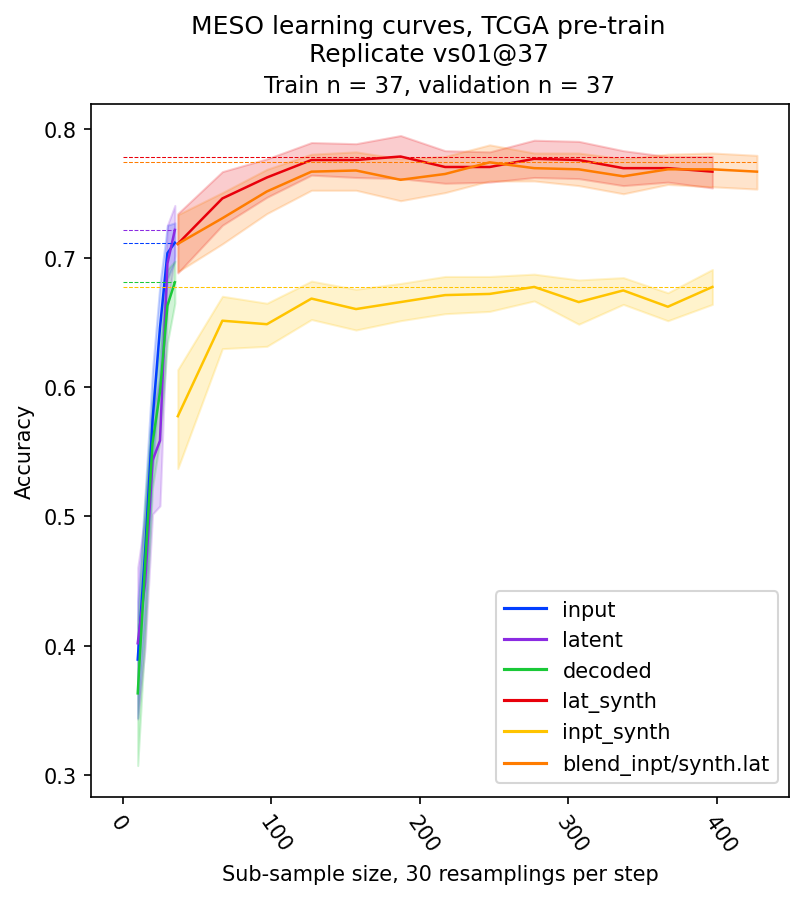

In [94]:
# Line curves
figure(figsize=(6, 6), dpi=150)
palette=[inp_blu, lat_prp, dec_grn,
         syn_lat_red, syn_inp_yel, syn_blnd_org]

phase_list = ['input', 'latent', 'decoded',
              'lat_synth', 'inpt_synth', 'blend_inp/synth.frm.ltnt']

ax = sns.lineplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=line_curve_frame, linewidth = 1.2)

for i, phase in enumerate(line_curve_frame.data_phase.unique()):
    max_val_lst = []
    phs_frm = line_curve_frame[line_curve_frame.data_phase == phase]
    for step_size in phs_frm.step_size.unique():
        step_frame = phs_frm[phs_frm.step_size == step_size]
        max_val_lst.append(mean(step_frame.Accuracy))

    phs_max = max(max_val_lst)
    plt.plot((0, phs_frm.step_size.max()), (phs_max, phs_max), '--', color = palette[i], linewidth = .5)
    
plt.suptitle(trn.index.name+' learning curves, '+'TCGA pre-train'+
            '\nReplicate '+val_split)
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size, '+str(resmpl_count)+' resamplings per step')
plt.legend(loc=(.58,.02))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.yticks()
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'_line.png', bbox_inches = 'tight')
print(val_split+' done')

## Front-end box

In [ ]:
# Run after each replicate - no

In [ ]:
inpt_summ = pd.DataFrame(data = inpt_val.iloc[9,:])
inpt_summ.insert(0, 'Take-off_point', 'input')

In [ ]:
lat_summ = pd.DataFrame(data = lat_val.iloc[9,:])
lat_summ.insert(0, 'Take-off_point', 'latent')

In [ ]:
dec_summ = pd.DataFrame(data = dec_val.iloc[9,:])
dec_summ.insert(0, 'Take-off_point', 'decoded')

In [ ]:
syn_lat_summ = pd.DataFrame(data = synth_lat_val.iloc[9,:])
syn_lat_summ.insert(0, 'Take-off_point', 'latent_synth')

In [ ]:
syn_inpt_summ = pd.DataFrame(data = synth_inpt_val.iloc[9,:])
syn_inpt_summ.insert(0, 'Take-off_point', 'input_synth')

In [ ]:
blnd_inpt_latSynth = pd.concat([pd.DataFrame(data = synth_lat_val.iloc[9,:]), 
                                pd.DataFrame(data = inpt_val.iloc[9,:])], axis = 0)
blnd_inpt_latSynth.insert(0, 'Take-off_point', 'blend_inpt/lat.synth')

In [ ]:
summ = pd.concat([inpt_summ, lat_summ, dec_summ, syn_lat_summ, syn_inpt_summ])

In [ ]:
my_pal = {'input': plt.cm.Paired(1),
          'decoded': plt.cm.Paired(3),
          'latent_synth': plt.cm.Paired(7),
          'input_synth': 'orange'}

# figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(summ, x='Take-off_point', y='Accuracy',
           palette = my_pal)

# add_stat_annotation(ax,
#                     data=summ,
#                     x='Take-off_point',
#                     y='Accuracy',
#                     # order=order,
#                     box_pairs=[('input', 'decoded'),
#                               ('input', 'latent_synth'),
#                               ('input', 'input_synth')
#                               ],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.suptitle(trn.index.name+' direct train and decode, five replicates')
plt.title('Train set n = '+str(len(trn))+' validation set n = '+str(len(val)),
         fontsize = 10)
plt.savefig('i_o/'+v+'/'+trn.index.name+'_front_end_box_'+str(
    repeats)+'_repeats.png', bbox_inches = 'tight')

### Colors

In [ ]:
# Add max input (blue) dashed line and value annotation
# Add max synthetic value annotation and line 

In [ ]:
#e22cf6   pink

In [ ]:
#62f62c   green

In [ ]:
#a31fe0    purple

#### Standard colors

In [207]:
sns.color_palette("YlOrBr", 8)

[(1.0, 0.9724413687043445, 0.7568012302960401),
 (0.9970319108035371, 0.9092656670511341, 0.6096270665128797),
 (0.996078431372549, 0.8091503267973856, 0.39607843137254906),
 (0.996078431372549, 0.6767089580930412, 0.22857362552864285),
 (0.9639677047289504, 0.5268589004229143, 0.12332179930795847),
 (0.8836601307189543, 0.39215686274509803, 0.054901960784313725),
 (0.7513725490196079, 0.27515570934256056, 0.009750096116878123),
 (0.5756862745098039, 0.19677047289504038, 0.016639753940792004)]

In [208]:
sns.color_palette("Greens", 8)

[(0.9066205305651672, 0.9641214917339485, 0.8884429065743944),
 (0.8089965397923875, 0.9251672433679354, 0.7834525182622069),
 (0.681045751633987, 0.8718954248366013, 0.6562091503267974),
 (0.5351787773933102, 0.8060899653979239, 0.5287504805843906),
 (0.36392156862745095, 0.7240292195309497, 0.4181468665897732),
 (0.21568627450980393, 0.6287581699346405, 0.3333333333333333),
 (0.10388312187620147, 0.5164936562860438, 0.2467512495194156),
 (0.0, 0.4079046520569012, 0.16444444444444445)]

In [209]:
sns.color_palette("Blues", 8)

[(0.8825067281814687, 0.929196462898885, 0.9724413687043445),
 (0.7993540945790081, 0.8740792003075739, 0.944882737408689),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 (0.5105882352941177, 0.7323029603998462, 0.8588389081122645),
 (0.34646674356016915, 0.632402921953095, 0.8106728181468666),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719),
 (0.10557477893118032, 0.41262591311034214, 0.6859669357939254),
 (0.03137254901960784, 0.301914648212226, 0.588404459823145)]

In [213]:
sns.color_palette("Spectral", 8)

[(0.8472126105344099, 0.2612072279892349, 0.30519031141868513),
 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9977700884275279, 0.930872741253364, 0.6330642060745867),
 (0.944252210688197, 0.9777008842752788, 0.6620530565167244),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.4530565167243369, 0.7815455594002307, 0.6462898885044214),
 (0.21607074202229912, 0.5556324490580546, 0.7319492502883507)]

In [224]:
sns.color_palette("Spectral", 6)

[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]

#### Special colors

In [223]:
sns.color_palette("mako", 10)

[(0.13701138, 0.08259683, 0.15060265),
 (0.20976258, 0.14925954, 0.29687795),
 (0.25007383, 0.22365053, 0.45519562),
 (0.23807973, 0.32226344, 0.58941872),
 (0.21112526, 0.42903064, 0.6266318),
 (0.20418396, 0.53013715, 0.64946117),
 (0.20968223, 0.63088252, 0.6701105),
 (0.26604085, 0.73564353, 0.67914062),
 (0.4285828, 0.82635051, 0.6780564),
 (0.68051833, 0.88963189, 0.75150483)]

In [166]:
sns.color_palette("viridis", 8)

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [203]:
sns.color_palette("viridis", 10)

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

In [167]:
sns.color_palette("magma", 8)

[(0.092949, 0.059904, 0.239164),
 (0.265447, 0.060237, 0.46184),
 (0.445163, 0.122724, 0.506901),
 (0.620005, 0.18384, 0.497524),
 (0.804752, 0.249911, 0.442102),
 (0.944006, 0.377643, 0.365136),
 (0.992196, 0.587502, 0.406299),
 (0.996369, 0.791167, 0.553499)]

In [226]:
sns.color_palette("magma", 14)

[(0.04383, 0.03383, 0.141886),
 (0.123833, 0.067295, 0.295879),
 (0.232077, 0.059889, 0.437695),
 (0.341482, 0.080564, 0.492631),
 (0.445163, 0.122724, 0.506901),
 (0.550287, 0.161158, 0.505719),
 (0.658483, 0.196027, 0.490253),
 (0.767398, 0.233705, 0.457755),
 (0.868793, 0.287728, 0.409303),
 (0.944006, 0.377643, 0.365136),
 (0.981, 0.498428, 0.369734),
 (0.994738, 0.62435, 0.427397),
 (0.997228, 0.747981, 0.516859),
 (0.99317, 0.870024, 0.626189)]

In [168]:
sns.color_palette("magma", 8)[1]

(0.265447, 0.060237, 0.46184)

In [170]:
sns.color_palette("rocket", 8)

[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

In [229]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### Color templates

In [ ]:
sns.color_palette("magma", 14)[0]

In [ ]:
sns.color_palette("mako", 10)[3]

In [ ]:
sns.color_palette("viridis", 8)[4]

In [ ]:
sns.color_palette("rocket", 8)[3]

In [ ]:
sns.color_palette("magma", 8)[5]

In [ ]:
sns.color_palette("viridis", 10)[9]

#### Bright

In [230]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [ ]:
0 blue input
4 purp lat
2 green decoded

3 red synth.lat
8 yellow synth.input
1 orange blend_input/synth.lat

In [332]:
max(line_curve_frame[line_curve_frame.data_phase == 'input'].Accuracy)

0.7823834196891192

In [333]:
max(line_curve_frame[line_curve_frame.data_phase == 'lat_synth'].Accuracy)

0.7849740932642487

In [ ]:
line_curve_frame

In [398]:
red_max = mean(line_curve_frame[line_curve_frame.data_phase == 'lat_synth'].Accuracy)

In [413]:
inp_frm

,data_phase,step_size,Accuracy,Validation_split
0,input,10,0.295337,vs05@74
1,input,10,0.295337,vs05@74
2,input,10,0.427461,vs05@74
3,input,10,0.277202,vs05@74
4,input,10,0.310881,vs05@74
...,...,...,...,...
25,input,70,0.694301,vs05@74
26,input,70,0.696891,vs05@74
27,input,70,0.707254,vs05@74
28,input,70,0.689119,vs05@74


In [ ]:
# notes: GTEX
    # push back down sub sample size